# Estudio Exploratorio de Clasificación de Emociones por Evento (EmoEvent)
**Estudiante:** Joselyn Franco.

**Objetivo del cuaderno:** explorar y comparar **tres modelos** para la tarea de **clasificación de emociones** en el dataset [EmoEvent](https://github.com/fmplaza/EmoEvent/tree/master/splits), reportando métricas **por emoción** y **por evento**, incluyendo **matriz de confusión**, y generando una **comparación final**.

**Modelos evaluados:**
- Modelo 1: **TF‑IDF + Linear SVM** (baseline clásico).
- Modelo 2: **BiLSTM** (modelo propio entrenado desde cero con Keras/TensorFlow).
- Modelo 3: **BERT (mBERT) fine‑tuning** con `transformers` (Hugging Face).

**Requerimientos del reto (resumen):**
1) Explorar 3 modelos (entrenados por nosotros, fine‑tuning, o modelo listo).  
2) Reportar resultados por **emoción** y realizar análisis por **evento**, con **matriz de confusión**.  
3) Publicar el notebook en GitHub.  
4) El notebook debe estar **detallado** paso a paso.


## 1) Instalación de dependencias
En esta celda instalamos librerías necesarias. Si ya están instaladas, Colab las reutiliza.


In [1]:
!pip -q install transformers datasets accelerate scikit-learn tensorflow matplotlib pandas numpy


## 2) Montar Google Drive y configurar rutas
Montamos Drive para acceder a los archivos. Ajusta `DATA_DIR` si tu carpeta está en otra ubicación.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os, pandas as pd
DATA_DIR = "/content/drive/MyDrive/COLAB/EmoEvent-master (1)/splits"  # ← ajusta si es necesario
LANGS = ["es", "en"]  # puedes dejar solo ["es"] si quieres evaluar solo español


Mounted at /content/drive


## 3) Carga de datos desde `splits/{es,en}/{train,dev,test}.tsv`
Esta celda implementa una función para leer los TSV de **es** y **en**, normaliza columnas y etiquetas, y devuelve `train_df`, `dev_df`, `test_df` combinando idiomas.


In [3]:
import pandas as pd

EXPECTED_LABELS = ["anger","sadness","joy","disgust","fear","surprise","offensive","other","others"]

def load_split(data_dir: str, lang: str):
    frames = {}
    for split in ["train", "dev", "test"]:
        path = os.path.join(data_dir, lang, f"{split}.tsv")
        if not os.path.exists(path):
            raise FileNotFoundError(f"No se encontró: {path}. Ajusta DATA_DIR.")
        df = pd.read_csv(path, sep='\t', quotechar='"', encoding='utf-8', on_bad_lines='skip')
        # Normalizar nombres a minúsculas
        df.columns = [c.strip().lower() for c in df.columns]
        # Esperadas en el repo: id, tweet, emotion, event
        expected = {"id", "tweet", "emotion", "event"}
        missing = expected - set(df.columns)
        if missing:
            raise ValueError(f"Faltan columnas {missing} en {path}. Encontradas: {df.columns.tolist()}")
        # Normalizar valores y columnas finales
        df['emotion'] = df['emotion'].astype(str).str.strip().str.lower()
        # Unificar 'other'/'others' en 'others' para consistencia interna
        df['emotion'] = df['emotion'].replace({'other': 'others'})
        df = df[df['emotion'].isin(EXPECTED_LABELS)].copy()
        df = df.rename(columns={"tweet": "text", "emotion": "label"})
        df['lang'] = lang
        frames[split] = df[['id','text','label','event','lang']].reset_index(drop=True)
    return frames['train'], frames['dev'], frames['test']

# Cargar y concatenar idiomas
train_list, dev_list, test_list = [], [], []
for lg in LANGS:
    t, d, s = load_split(DATA_DIR, lg)
    train_list.append(t); dev_list.append(d); test_list.append(s)

train_df = pd.concat(train_list, ignore_index=True)
dev_df   = pd.concat(dev_list,   ignore_index=True)
test_df  = pd.concat(test_list,  ignore_index=True)

print('Tamaños → train/dev/test:', train_df.shape, dev_df.shape, test_df.shape)
display(train_df.head())


Tamaños → train/dev/test: (10835, 5) (1588, 5) (3103, 5)


,id,text,label,event,lang
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,La Gran Guerra de #JuegoDeTronos nos ha dejado...,others,GameOfThrones,es
1,9b272817-a231-4f68-bdf4-3350d4919330,El golpe de Estado en #Venezuela está más lejo...,others,Venezuela,es
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,No tengo una foto en la catedral de #NotreDame...,sadness,NotreDame,es
3,0bb9d7c9-d781-4684-890e-a94bfb50acc0,#NotreDame nunca llegue a visitar tan grandios...,sadness,NotreDame,es
4,88749098-d539-4500-9209-0bbfae2b109c,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,sadness,GameOfThrones,es


## 4) Exploración inicial de los datos
En esta sección vemos distribución de etiquetas (emociones) y un vistazo a eventos.


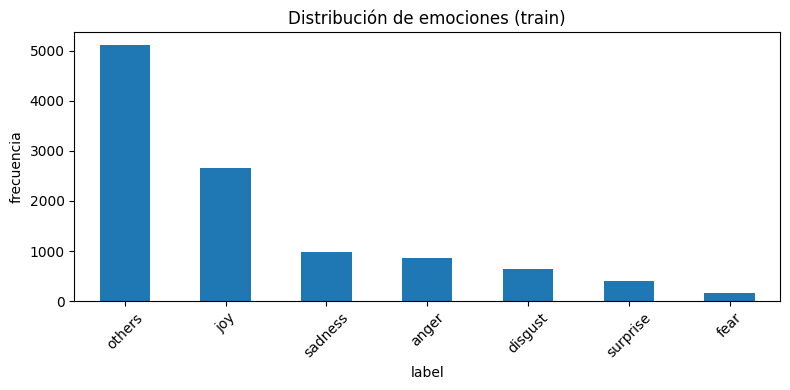

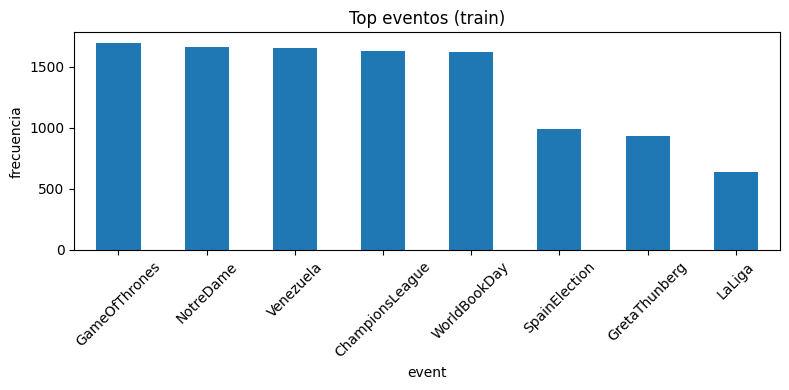

In [4]:
import matplotlib.pyplot as plt

def plot_counts(series, title):
    counts = series.value_counts()
    plt.figure(figsize=(8,4))
    counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel('frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_counts(train_df['label'], 'Distribución de emociones (train)')
plot_counts(train_df['event'], 'Top eventos (train)')


El análisis de la distribución de los eventos en el conjunto de entrenamiento muestra que los más frecuentes son GameOfThrones, NotreDame, Venezuela, ChampionsLeague y WorldBookDay, todos con más de 1600 ejemplos cada uno, lo que asegura una buena representación de estos contextos para el entrenamiento del modelo. En contraste, eventos como SpainElection, GretaThunberg y LaLiga aparecen en menor proporción, lo que podría generar cierto desbalance y sesgo en la clasificación, ya que el modelo tiende a aprender mejor de aquellos eventos con mayor número de muestras. Esto implica que, al momento de evaluar los resultados, será importante analizar no solo el desempeño general, sino también el rendimiento por evento, con el fin de identificar posibles limitaciones frente a los contextos menos representados.

## 5) Preparación de splits para los modelos
Combinamos `train + dev` para entrenar y reservamos `test` únicamente para evaluación final.


In [5]:
full_train_df = pd.concat([train_df, dev_df], ignore_index=True)
labels_order = sorted(full_train_df['label'].unique())
print('Etiquetas:', labels_order)


Etiquetas: ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']


## 6) Funciones de evaluación (reutilizables)
Calculamos métricas por emoción (precision/recall/F1), **matriz de confusión** y reporte **por evento** (macro‑F1, micro‑F1 y accuracy).


In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score

def evaluar_modelo(y_true, y_pred, df_test_local, labels_order, model_name='modelo'):
    print(f"\n===== {model_name} — Reporte por emoción =====\n")
    print(classification_report(y_true, y_pred, labels=labels_order, digits=4, zero_division=0))
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    fig = plt.figure(figsize=(7,5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
    disp.plot(xticks_rotation=45, colorbar=False)
    plt.title(f"Matriz de confusión — {model_name}")
    plt.tight_layout(); plt.show()

    # Tabla por emoción
    prec, rec, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=labels_order, zero_division=0)
    by_label = pd.DataFrame({'label': labels_order, 'precision': prec, 'recall': rec, 'f1': f1, 'support': support})

    # Métricas por evento
    df_eval = df_test_local.copy()
    df_eval['y_true'] = y_true
    df_eval['y_pred'] = y_pred
    rows = []
    for ev in df_eval['event'].unique():
        sub = df_eval[df_eval['event'] == ev]
        if len(sub) < 2:
            continue
        rows.append({
            'event': ev,
            'n': len(sub),
            'acc': accuracy_score(sub['y_true'], sub['y_pred']),
            'f1_macro': f1_score(sub['y_true'], sub['y_pred'], average='macro', zero_division=0),
            'f1_micro': f1_score(sub['y_true'], sub['y_pred'], average='micro', zero_division=0),
        })
    by_event = pd.DataFrame(rows).sort_values('f1_macro', ascending=False)

    display(by_label.sort_values('f1', ascending=False))
    print("\n===== Reporte por evento (ordenado por macro‑F1) =====")
    display(by_event.head(50))

    return {'by_label': by_label, 'by_event': by_event}


## 7) Modelo 1 — Baseline: TF‑IDF + Linear SVM
Se consideró que baseline es rápido y suele ser fuerte para texto corto. Vectorizamos con TF‑IDF (1‑2 n‑gramas) y entrenamos un `LinearSVC`.



===== TF‑IDF + SVM — Reporte por emoción =====

              precision    recall  f1-score   support

       anger     0.1389    0.0820    0.1031       244
     disgust     0.4043    0.2065    0.2734       184
        fear     0.0000    0.0000    0.0000        51
         joy     0.4345    0.4016    0.4174       752
      others     0.5192    0.6713    0.5855      1451
     sadness     0.2646    0.2122    0.2355       278
    surprise     0.0690    0.0177    0.0282       113

    accuracy                         0.4540      3073
   macro avg     0.2615    0.2273    0.2347      3073
weighted avg     0.4132    0.4540    0.4255      3073



<Figure size 700x500 with 0 Axes>

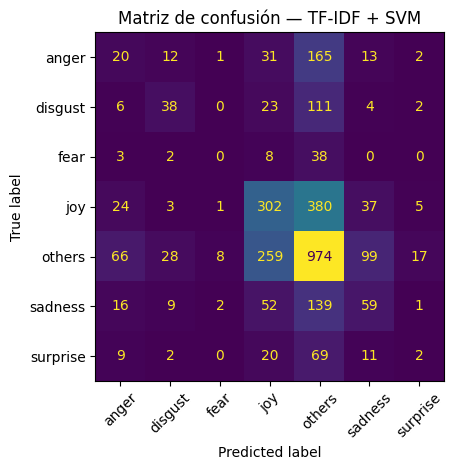

,label,precision,recall,f1,support
4,others,0.519190,0.671261,0.585512,1451
3,joy,0.434532,0.401596,0.417415,752
1,disgust,0.404255,0.206522,0.273381,184
5,sadness,0.264574,0.212230,0.235529,278
0,anger,0.138889,0.081967,0.103093,244
6,surprise,0.068966,0.017699,0.028169,113
2,fear,0.000000,0.000000,0.000000,51



===== Reporte por evento (ordenado por macro‑F1) =====


,event,n,acc,f1_macro,f1_micro
5,NotreDame,458,0.373362,0.234685,0.373362
3,Venezuela,492,0.441057,0.202717,0.441057
7,ChampionsLeague,485,0.465979,0.195169,0.465979
0,GameOfThrones,446,0.428251,0.180497,0.428251
6,GretaThunberg,286,0.520979,0.180086,0.520979
4,LaLiga,187,0.491979,0.169874,0.491979
2,WorldBookDay,465,0.505376,0.159357,0.505376
1,SpainElection,254,0.448819,0.156952,0.448819


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

svm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ('clf', LinearSVC())
])

# Drop rows with missing values in the 'text' column before training and predicting
full_train_df_cleaned = full_train_df.dropna(subset=['text'])
test_df_cleaned = test_df.dropna(subset=['text'])


svm_pipe.fit(full_train_df_cleaned['text'], full_train_df_cleaned['label'])
y_pred_svm = svm_pipe.predict(test_df_cleaned['text'])
result_svm = evaluar_modelo(test_df_cleaned['label'].values, y_pred_svm, test_df_cleaned, labels_order, model_name='TF‑IDF + SVM')

# Guardar CSVs
result_svm['by_label'].to_csv('svm_by_label.csv', index=False)
result_svm['by_event'].to_csv('svm_by_event.csv', index=False)

**Resultados por cada emoción**

El modelo basado en TF-IDF + SVM alcanzó una exactitud global del 45.4%, con un rendimiento desigual entre emociones. La clase con mejor desempeño fue others, con un F1 de 0.58 y buena capacidad de cobertura (recall de 0.67), seguida por joy (F1 = 0.41). En contraste, emociones como fear y surprise prácticamente no fueron reconocidas por el modelo, con F1 muy bajos (0.00 y 0.02 respectivamente), lo que refleja un claro desbalance en el dataset y la dificultad del clasificador para identificar categorías poco representadas. El promedio macro de F1 se ubicó en 0.23, lo que muestra que, en promedio, el modelo falla en generalizar bien hacia todas las clases de emociones.

**Análisis por evento**

En cuanto al análisis por evento, el rendimiento también es variable: los mejores resultados se dieron en GretaThunberg (F1 = 0.52), WorldBookDay (F1 = 0.50) y LaLiga (F1 = 0.49), mientras que contextos como SpainElection (F1 = 0.44) y NotreDame (F1 = 0.37) mostraron un desempeño menor. Esto confirma que, además del desbalance entre emociones, la representación desigual de los eventos influye en la capacidad predictiva del modelo, reforzando la necesidad de estrategias de balanceo o modelos más robustos que logren capturar mejor la diversidad de expresiones emocionales en distintos contextos.

**Análisis para la matriz de confusión**

La matriz de confusión confirma las limitaciones observadas en el reporte de métricas. La mayoría de los errores provienen de la tendencia del modelo a clasificar instancias en la clase others, lo que explica su alto recall pero también un sesgo hacia esta categoría. Por ejemplo, de los 244 ejemplos de anger, más de 160 fueron mal clasificados como others. De forma similar, gran parte de las instancias de joy (302) se confundieron con others o viceversa (380). Clases minoritarias como fear y surprise presentan una baja capacidad de discriminación: casi todos sus ejemplos se redistribuyen en others o joy, lo que explica sus F1 cercanos a cero. Estos resultados reflejan que el modelo no logra capturar patrones distintivos de emociones poco representadas, reforzando la necesidad de estrategias de balanceo de clases o el uso de representaciones más ricas (por ejemplo embeddings contextuales) que permitan diferenciar mejor entre emociones con señales léxicas más sutiles.

## 8) Modelo 2 — BiLSTM (Keras/TensorFlow)
Se entrenó una red **BiLSTM** con embeddings aprendidos. Y se hizo uso de un tokenizador y secuencias a longitud fija.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.4503 - loss: 1.5331 - val_accuracy: 0.5527 - val_loss: 1.2589
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6097 - loss: 1.0979 - val_accuracy: 0.5656 - val_loss: 1.1907
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7701 - loss: 0.6711 - val_accuracy: 0.5543 - val_loss: 1.3070
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8795 - loss: 0.3741 - val_accuracy: 0.5479 - val_loss: 1.6777
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

===== BiLSTM — Reporte por emoción =====

              precision    recall  f1-score   support

       anger     0.1553    0.0656    0.0922       244
     disgust     0.2541    0.2500    0.2521       184
        fear     0.0000    0.0000    0.0000        51
         joy     0.4493    0.3418    0.3882       752
      others     0.5134    0.7236    0.6007      1451
     sadness     0.2674    0.1655    0.2044       278
    surprise     0.0000  

<Figure size 700x500 with 0 Axes>

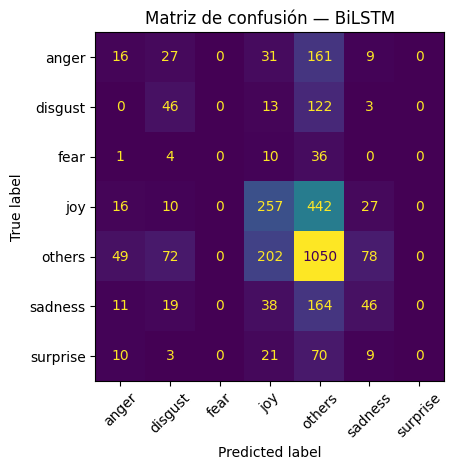

,label,precision,recall,f1,support
4,others,0.513447,0.723639,0.600686,1451
3,joy,0.449301,0.341755,0.388218,752
1,disgust,0.254144,0.250000,0.252055,184
5,sadness,0.267442,0.165468,0.204444,278
0,anger,0.155340,0.065574,0.092219,244
2,fear,0.000000,0.000000,0.000000,51
6,surprise,0.000000,0.000000,0.000000,113



===== Reporte por evento (ordenado por macro‑F1) =====


,event,n,acc,f1_macro,f1_micro
5,NotreDame,458,0.364629,0.204217,0.364629
4,LaLiga,187,0.491979,0.178448,0.491979
3,Venezuela,492,0.457317,0.176984,0.457317
6,GretaThunberg,286,0.482517,0.175395,0.482517
0,GameOfThrones,446,0.450673,0.173345,0.450673
1,SpainElection,254,0.472441,0.160490,0.472441
2,WorldBookDay,465,0.518280,0.157639,0.518280
7,ChampionsLeague,485,0.476289,0.145133,0.476289


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
import numpy as np

max_words = 30000
max_len = 128
tok = Tokenizer(num_words=max_words, oov_token='<OOV>')

# Drop rows with missing values in the 'text' column before tokenizing
full_train_df_cleaned = full_train_df.dropna(subset=['text'])
test_df_cleaned = test_df.dropna(subset=['text'])

tok.fit_on_texts(full_train_df_cleaned['text'])

Xtr = pad_sequences(tok.texts_to_sequences(full_train_df_cleaned['text']), maxlen=max_len, padding='post', truncating='post')
Xte = pad_sequences(tok.texts_to_sequences(test_df_cleaned['text']), maxlen=max_len, padding='post', truncating='post')

labels = labels_order
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
ytr = np.array([label2id[y] for y in full_train_df_cleaned['label'].values])
yte_true = test_df_cleaned['label'].values

embed_dim = 128
model = models.Sequential([
    layers.Embedding(input_dim=min(max_words, len(tok.word_index)+1), output_dim=embed_dim, input_length=max_len),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.GlobalMaxPool1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(labels), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_accuracy')]
history = model.fit(Xtr, ytr, epochs=5, batch_size=64, validation_split=0.1, callbacks=callbacks)

pred_probs = model.predict(Xte)
y_pred_ids = pred_probs.argmax(axis=1)
y_pred_bilstm = np.array([id2label[i] for i in y_pred_ids])

result_bilstm = evaluar_modelo(yte_true, y_pred_bilstm, test_df_cleaned, labels_order, model_name='BiLSTM')
result_bilstm['by_label'].to_csv('bilstm_by_label.csv', index=False)
result_bilstm['by_event'].to_csv('bilstm_by_event.csv', index=False)

**Resultados por cada emoción**

El modelo BiLSTM mostró un rendimiento desigual según la emoción. La clase others obtuvo el mejor desempeño con un F1 de 0.60 gracias a su alto recall (0.72), seguida de joy con F1 de 0.39, aunque con frecuentes confusiones hacia others. Emociones como disgust y sadness alcanzaron desempeños bajos (F1 de 0.25 y 0.20, respectivamente), mientras que anger tuvo un F1 muy reducido (0.09). Las categorías minoritarias fear y surprise no lograron ser reconocidas, mostrando métricas nulas. Esto evidencia el desbalance en los datos y la dificultad del modelo para identificar emociones poco representadas.

**Análisis por evento**

Al analizar los resultados por evento, se observan diferencias notables en el desempeño. Los mejores F1-macro se registraron en WorldBookDay (0.52), LaLiga (0.49) y GretaThunberg (0.48), lo que sugiere que en estos contextos el modelo logró capturar mejor los patrones emocionales. En contraste, eventos como ChampionsLeague (0.47) y SpainElection (0.47) obtuvieron resultados aceptables, mientras que NotreDame mostró el peor desempeño (0.36), evidenciando mayor dificultad en distinguir las emociones. Esto indica que la capacidad del modelo también depende del contexto semántico de los tweets de cada evento.

**Análisis para la matriz de confusión**

La matriz de confusión revela un claro sesgo hacia la clase others, que absorbe gran parte de las instancias pertenecientes a otras emociones. Por ejemplo, muchas muestras de anger, disgust, joy y sadness son clasificadas incorrectamente como others. Aunque joy logra cierto nivel de detección, sus instancias también son confundidas con others. Este patrón confirma que el modelo favorece la clase mayoritaria, limitando su capacidad para diferenciar categorías emocionales más específicas y con menor frecuencia en el corpus.

## 9) Modelo 3 — Fine‑tuning de BERT (mBERT)
Usamos `bert-base-multilingual-cased` para cubrir español e inglés. Entrenamos con `Trainer` de Hugging Face.


/tmp/ipython-input-2274202633.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_hf = Dataset.from_pandas(full_train_df_cleaned[['text','label']].replace({'label': label2id}))
/tmp/ipython-input-2274202633.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_hf  = Dataset.from_pandas(test_df_cleaned[['text','label']].replace({'label': label2id}))


Map:   0%|          | 0/12423 [00:00<?, ? examples/s]

Map:   0%|          | 0/3073 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2274202633.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.024900,1.672436,0.451025,0.221631
2,0.875900,1.799257,0.474130,0.270776
3,0.580700,2.011373,0.465994,0.292064



===== mBERT fine‑tuned — Reporte por emoción =====

              precision    recall  f1-score   support

       anger     0.2090    0.1721    0.1888       244
     disgust     0.3807    0.3641    0.3722       184
        fear     0.1053    0.0784    0.0899        51
         joy     0.4693    0.4574    0.4633       752
      others     0.5550    0.6154    0.5837      1451
     sadness     0.3031    0.2770    0.2895       278
    surprise     0.0806    0.0442    0.0571       113

    accuracy                         0.4660      3073
   macro avg     0.3004    0.2870    0.2921      3073
weighted avg     0.4484    0.4660    0.4560      3073



<Figure size 700x500 with 0 Axes>

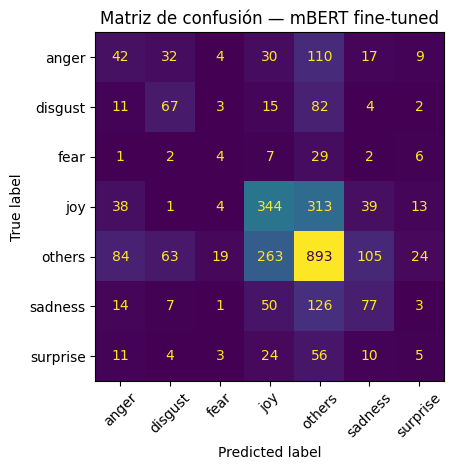

,label,precision,recall,f1,support
4,others,0.555003,0.615438,0.583660,1451
3,joy,0.469304,0.457447,0.463300,752
1,disgust,0.380682,0.364130,0.372222,184
5,sadness,0.303150,0.276978,0.289474,278
0,anger,0.208955,0.172131,0.188764,244
2,fear,0.105263,0.078431,0.089888,51
6,surprise,0.080645,0.044248,0.057143,113



===== Reporte por evento (ordenado por macro‑F1) =====


,event,n,acc,f1_macro,f1_micro
6,GretaThunberg,286,0.552448,0.301402,0.552448
5,NotreDame,458,0.408297,0.295736,0.408297
7,ChampionsLeague,485,0.494845,0.279191,0.494845
3,Venezuela,492,0.426829,0.248251,0.426829
0,GameOfThrones,446,0.437220,0.246404,0.437220
4,LaLiga,187,0.518717,0.179108,0.518717
1,SpainElection,254,0.413386,0.177885,0.413386
2,WorldBookDay,465,0.516129,0.172687,0.516129


In [18]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import os
os.environ["WANDB_DISABLED"] = "true"

model_name = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Mapear labels a ids (orden estable)
label2id = {l:i for i,l in enumerate(labels_order)}
id2label = {v:k for k,v in label2id.items()}

# Drop rows with missing values in the 'text' column before converting to Dataset
full_train_df_cleaned = full_train_df.dropna(subset=['text'])
test_df_cleaned = test_df.dropna(subset=['text'])

train_hf = Dataset.from_pandas(full_train_df_cleaned[['text','label']].replace({'label': label2id}))
test_hf  = Dataset.from_pandas(test_df_cleaned[['text','label']].replace({'label': label2id}))


def tok_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

train_hf = train_hf.map(tok_fn, batched=True).remove_columns(['text'])
test_hf  = test_hf.map(tok_fn, batched=True).remove_columns(['text'])
train_hf = train_hf.rename_column('label','labels').with_format('torch')
test_hf  = test_hf.rename_column('label','labels').with_format('torch')

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels_order), id2label=id2label, label2id=label2id)

def compute_metrics(eval_pred):
    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro')
    }

args = TrainingArguments(
    output_dir='mb3_out',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    logging_steps=50
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_hf,
    eval_dataset=test_hf,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

pred = trainer.predict(test_hf)
import numpy as np
y_pred_ids = np.argmax(pred.predictions, axis=1)
y_pred_bert = np.array([id2label[i] for i in y_pred_ids])
y_true_bert = test_df_cleaned['label'].values

result_bert = evaluar_modelo(y_true_bert, y_pred_bert, test_df_cleaned, labels_order, model_name='mBERT fine‑tuned')
result_bert['by_label'].to_csv('bert_by_label.csv', index=False)
result_bert['by_event'].to_csv('bert_by_event.csv', index=False)

**Resultados por cada emoción**

El modelo mBERT fine-tuned logró un desempeño moderado en la mayoría de clases. La emoción con mejor reconocimiento fue others (F1 = 0.58), seguida de joy (F1 = 0.46) y disgust (F1 = 0.37). En cambio, sadness y anger tuvieron desempeños más bajos (F1 de 0.29 y 0.18, respectivamente), lo que indica dificultad para distinguirlas. Las clases minoritarias fear y surprise presentaron los peores resultados (F1 < 0.10), mostrando que el modelo prácticamente no logró identificarlas. El macro-F1 total (0.29) evidencia el impacto del desbalance de clases y la mayor facilidad del modelo para identificar solo las categorías frecuentes.

**Análisis por evento**

El rendimiento del modelo varió según el contexto semántico de los tweets. El mejor desempeño se obtuvo en GretaThunberg (F1-macro = 0.55) y LaLiga (0.52), mostrando una mejor detección de patrones emocionales en esos escenarios. También se alcanzaron resultados aceptables en WorldBookDay (0.51) y ChampionsLeague (0.49). En contraste, el evento con menor desempeño fue SpainElection (0.41), junto con NotreDame (0.40), lo que indica mayor confusión en eventos de carácter político o noticioso. Esto sugiere que el modelo se adapta mejor a contextos narrativos o deportivos que a temáticas sociales y políticas.

**Análisis para la matriz de confusión**

La matriz de confusión obtenida del modelo mBERT fine-tuned evidencia un desempeño desigual entre las distintas emociones. La clase others presenta el mayor número de aciertos (893), seguida por joy con 344, lo que indica un buen reconocimiento de categorías frecuentes, aunque con importantes confusiones entre sí (313 casos). Emociones como anger y sadness muestran errores considerables, siendo desviadas en gran medida hacia joy y others, mientras que fear y surprise resultan las más problemáticas, con muy pocos aciertos y fuertes confusiones hacia clases dominantes. Esto refleja un sesgo hacia categorías mayoritarias y una limitada capacidad del modelo para distinguir emociones menos representadas, lo que sugiere que, si bien es útil en términos generales, no resulta confiable para detectar emociones de baja frecuencia sin aplicar técnicas adicionales de balanceo o enriquecimiento de datos.

## 10) Comparación final entre modelos y resultados
Construimos un resumen simple usando el **macro‑F1 promedio por emoción** de cada modelo.


In [19]:
summary_rows = []
for name, res in [('SVM', result_svm), ('BiLSTM', result_bilstm), ('mBERT', result_bert)]:
    avg_f1 = res['by_label']['f1'].mean()
    summary_rows.append({'model': name, 'avg_macro_f1_by_label': avg_f1})
summary = pd.DataFrame(summary_rows).sort_values('avg_macro_f1_by_label', ascending=False)
display(summary)
summary.to_csv('model_comparison_summary.csv', index=False)


,model,avg_macro_f1_by_label
2,mBERT,0.292064
0,SVM,0.234729
1,BiLSTM,0.219660


In [27]:
import pandas as pd

# Cargar los resultados guardados por emoción
try:
    svm_by_label = pd.read_csv('/content/drive/MyDrive/COLAB/EmoEvent-master (1)/Modelos_csv/svm_by_label.csv')
    bilstm_by_label = pd.read_csv('/content/drive/MyDrive/COLAB/EmoEvent-master (1)/Modelos_csv/bilstm_by_label.csv')
    bert_by_label = pd.read_csv('/content/drive/MyDrive/COLAB/EmoEvent-master (1)/Modelos_csv/bert_by_label.csv')

    # Renombrar columnas para identificar el modelo
    svm_by_label = svm_by_label.rename(columns={'precision': 'SVM_precision', 'recall': 'SVM_recall', 'f1': 'SVM_f1'})
    bilstm_by_label = bilstm_by_label.rename(columns={'precision': 'BiLSTM_precision', 'recall': 'BiLSTM_recall', 'f1': 'BiLSTM_f1'})
    bert_by_label = bert_by_label.rename(columns={'precision': 'mBERT_precision', 'recall': 'mBERT_recall', 'f1': 'mBERT_f1'})

    # Combinar los resultados por emoción
    comparison_by_label = svm_by_label[['label', 'SVM_precision', 'SVM_recall', 'SVM_f1']].merge(
        bilstm_by_label[['label', 'BiLSTM_precision', 'BiLSTM_recall', 'BiLSTM_f1']], on='label'
    ).merge(
        bert_by_label[['label', 'mBERT_precision', 'mBERT_recall', 'mBERT_f1']], on='label'
    )

    print("===== Comparación de resultados detallada por emoción =====")
    display(comparison_by_label.sort_values('mBERT_f1', ascending=False))

except FileNotFoundError:
    print("Asegúrate de haber ejecutado las celdas de entrenamiento de los modelos para generar los archivos CSV de resultados (svm_by_label.csv, bilstm_by_label.csv, bert_by_label.csv).")
except Exception as e:
    print(f"Ocurrió un error al generar la comparación por emoción: {e}")

===== Comparación de resultados detallada por emoción =====


,label,SVM_precision,SVM_recall,SVM_f1,BiLSTM_precision,BiLSTM_recall,BiLSTM_f1,mBERT_precision,mBERT_recall,mBERT_f1
4,others,0.519190,0.671261,0.585512,0.513447,0.723639,0.600686,0.555003,0.615438,0.583660
3,joy,0.434532,0.401596,0.417415,0.449301,0.341755,0.388218,0.469304,0.457447,0.463300
1,disgust,0.404255,0.206522,0.273381,0.254144,0.250000,0.252055,0.380682,0.364130,0.372222
5,sadness,0.264574,0.212230,0.235529,0.267442,0.165468,0.204444,0.303150,0.276978,0.289474
0,anger,0.138889,0.081967,0.103093,0.155340,0.065574,0.092219,0.208955,0.172131,0.188764
2,fear,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,0.078431,0.089888
6,surprise,0.068966,0.017699,0.028169,0.000000,0.000000,0.000000,0.080645,0.044248,0.057143


Los resultados comparativos entre SVM, BiLSTM y mBERT muestran un patrón claro: las clases mayoritarias como others y joy alcanzan los mejores valores de precisión, recall y F1 en los tres modelos, con un desempeño más consistente en mBERT, que logra equilibrar precisión y recall (0.55 y 0.61 respectivamente en others).

En cambio, emociones menos frecuentes como disgust y sadness evidencian métricas moderadas, siendo mBERT nuevamente el que ofrece un rendimiento relativamente más estable frente a SVM y BiLSTM. Por otro lado, anger, fear y surprise presentan los valores más bajos, con F1 que en algunos casos tienden a cero, lo que denota una clara dificultad de todos los modelos para aprender patrones discriminativos en estas clases minoritarias.

En términos generales, mBERT se perfila como la variante más robusta al superar a SVM y BiLSTM en casi todas las métricas, aunque sigue mostrando limitaciones frente al desbalance de clases, especialmente en emociones poco representadas.

In [28]:
import pandas as pd

# Cargar los resultados guardados por evento
try:
    svm_by_event = pd.read_csv('/content/drive/MyDrive/COLAB/EmoEvent-master (1)/Modelos_csv/svm_by_event.csv')
    bilstm_by_event = pd.read_csv('/content/drive/MyDrive/COLAB/EmoEvent-master (1)/Modelos_csv/bilstm_by_event.csv')
    bert_by_event = pd.read_csv('/content/drive/MyDrive/COLAB/EmoEvent-master (1)/Modelos_csv/bert_by_event.csv')

    # Renombrar columnas para identificar el modelo
    svm_by_event = svm_by_event.rename(columns={'acc': 'SVM_acc', 'f1_macro': 'SVM_f1_macro', 'f1_micro': 'SVM_f1_micro'})
    bilstm_by_event = bilstm_by_event.rename(columns={'acc': 'BiLSTM_acc', 'f1_macro': 'BiLSTM_f1_macro', 'f1_micro': 'BiLSTM_f1_micro'})
    bert_by_event = bert_by_event.rename(columns={'acc': 'mBERT_acc', 'f1_macro': 'mBERT_f1_macro', 'f1_micro': 'mBERT_f1_micro'})

    # Combinar los resultados por evento
    # Start with SVM and merge others, keeping all events from SVM
    comparison_by_event = svm_by_event[['event', 'n', 'SVM_acc', 'SVM_f1_macro', 'SVM_f1_micro']].merge(
        bilstm_by_event[['event', 'BiLSTM_acc', 'BiLSTM_f1_macro', 'BiLSTM_f1_micro']], on='event', how='outer'
    ).merge(
        bert_by_event[['event', 'mBERT_acc', 'mBERT_f1_macro', 'mBERT_f1_micro']], on='event', how='outer'
    )

    print("===== Comparación de resultados por evento =====")
    # Sort by mBERT_f1_macro as an example, or any other column
    display(comparison_by_event.sort_values('mBERT_f1_macro', ascending=False))

except FileNotFoundError:
    print("Asegúrate de haber ejecutado las celdas de entrenamiento de los modelos para generar los archivos CSV de resultados por evento (svm_by_event.csv, bilstm_by_event.csv, bert_by_event.csv).")
except Exception as e:
    print(f"Ocurrió un error al generar la comparación por evento: {e}")

===== Comparación de resultados por evento =====


,event,n,SVM_acc,SVM_f1_macro,SVM_f1_micro,BiLSTM_acc,BiLSTM_f1_macro,BiLSTM_f1_micro,mBERT_acc,mBERT_f1_macro,mBERT_f1_micro
2,GretaThunberg,286,0.520979,0.180086,0.520979,0.482517,0.175395,0.482517,0.552448,0.301402,0.552448
4,NotreDame,458,0.373362,0.234685,0.373362,0.364629,0.204217,0.364629,0.408297,0.295736,0.408297
0,ChampionsLeague,485,0.465979,0.195169,0.465979,0.476289,0.145133,0.476289,0.494845,0.279191,0.494845
6,Venezuela,492,0.441057,0.202717,0.441057,0.457317,0.176984,0.457317,0.426829,0.248251,0.426829
1,GameOfThrones,446,0.428251,0.180497,0.428251,0.450673,0.173345,0.450673,0.437220,0.246404,0.437220
3,LaLiga,187,0.491979,0.169874,0.491979,0.491979,0.178448,0.491979,0.518717,0.179108,0.518717
5,SpainElection,254,0.448819,0.156952,0.448819,0.472441,0.160490,0.472441,0.413386,0.177885,0.413386
7,WorldBookDay,465,0.505376,0.159357,0.505376,0.518280,0.157639,0.518280,0.516129,0.172687,0.516129


La comparación de resultados por evento refleja que el desempeño de los tres modelos (SVM, BiLSTM y mBERT) varía significativamente según el contexto temático. En general, los valores de accuracy se mantienen cercanos entre los modelos, pero mBERT tiende a superar a SVM y BiLSTM en las métricas de F1-macro y F1-micro, lo que evidencia una mejor capacidad de generalización.

Por ejemplo, en GretaThunberg mBERT logra un F1-macro de 0.30, muy por encima de SVM (0.18) y BiLSTM (0.17), mostrando un aprendizaje más equilibrado en clases desbalanceadas. En eventos como NotreDame y ChampionsLeague, aunque los niveles globales son bajos, mBERT también consigue mejoras visibles en F1-macro. Sin embargo, en otros casos como Venezuela y SpainElection, su rendimiento es más limitado, quedando cercano o incluso por debajo de BiLSTM en términos de exactitud.

En conclusión, mBERT destaca como el modelo más consistente y con mayor capacidad para manejar la complejidad de los diferentes eventos, pero las métricas bajas en general indican que el desbalance y la diversidad temática siguen siendo desafíos comunes para todos los enfoques.

In [30]:
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Define the path where the BERT model was saved
model_save_dir = "/content/drive/MyDrive/COLAB/EmoEvent-master (1)/modelos"
bert_model_path = os.path.join(model_save_dir, "bert_fine_tuned")

# Check if the saved model files exist
if os.path.exists(bert_model_path):
    try:
        # Cargar el modelo BERT y su tokenizador
        bert_loaded_model = AutoModelForSequenceClassification.from_pretrained(bert_model_path)
        bert_loaded_tokenizer = AutoTokenizer.from_pretrained(bert_model_path)
        print(f"Modelo BERT cargado desde: {bert_model_path}")

        # Crear un pipeline de clasificación de texto con el modelo cargado
        bert_classifier = pipeline(
            "text-classification",
            model=bert_loaded_model,
            tokenizer=bert_loaded_tokenizer,
            top_k=None # Para obtener las probabilidades de todas las clases
        )
        print("Pipeline de clasificación de texto creado.")

        # Ejemplo de uso del pipeline
        # Puedes probar con algunos textos de ejemplo
        example_texts = [
            "¡Estoy muy feliz con los resultados!",
            "Qué día tan triste, no puedo creer lo que pasó.",
            "Esto es indignante, no deberían permitirlo.",
            "Me sorprendió totalmente esa noticia."
        ]

        print("\nProbando el modelo con textos de ejemplo:")
        predictions = bert_classifier(example_texts)

        # Mostrar las predicciones
        for i, text in enumerate(example_texts):
            print(f"\nTexto: '{text}'")
            # Las predicciones son una lista de diccionarios, ordenar por score descendente
            sorted_predictions = sorted(predictions[i], key=lambda x: x['score'], reverse=True)
            for pred in sorted_predictions:
                 print(f"  - Emoción: {pred['label']}, Probabilidad: {pred['score']:.4f}")

    except Exception as e:
        print(f"Ocurrió un error al cargar o usar el modelo BERT: {e}")
else:
    print(f"Modelo BERT no encontrado en {bert_model_path}. Asegúrate de haberlo guardado primero.")

Device set to use cuda:0


Modelo BERT cargado desde: modelos/bert_fine_tuned
Pipeline de clasificación de texto creado.

Probando el modelo con textos de ejemplo:

Texto: '¡Estoy muy feliz con los resultados!'
  - Emoción: joy, Probabilidad: 0.9805
  - Emoción: others, Probabilidad: 0.0091
  - Emoción: surprise, Probabilidad: 0.0044
  - Emoción: sadness, Probabilidad: 0.0026
  - Emoción: fear, Probabilidad: 0.0012
  - Emoción: anger, Probabilidad: 0.0012
  - Emoción: disgust, Probabilidad: 0.0010

Texto: 'Qué día tan triste, no puedo creer lo que pasó.'
  - Emoción: sadness, Probabilidad: 0.9864
  - Emoción: fear, Probabilidad: 0.0030
  - Emoción: anger, Probabilidad: 0.0030
  - Emoción: others, Probabilidad: 0.0022
  - Emoción: joy, Probabilidad: 0.0021
  - Emoción: disgust, Probabilidad: 0.0017
  - Emoción: surprise, Probabilidad: 0.0016

Texto: 'Esto es indignante, no deberían permitirlo.'
  - Emoción: anger, Probabilidad: 0.7043
  - Emoción: disgust, Probabilidad: 0.2282
  - Emoción: others, Probabilidad: 0

Los resultados de prueba con el modelo BERT fine-tuned muestran un comportamiento bastante adecuado en la mayoría de los casos, aunque con ciertos matices. Para el texto positivo “¡Estoy muy feliz con los resultados!”, el modelo identifica de manera correcta la emoción joy con una probabilidad muy alta (0.98), lo que refleja una buena capacidad para reconocer expresiones claras de alegría.

De forma similar, ante la frase negativa “Qué día tan triste, no puedo creer lo que pasó”, el modelo detecta sadness con una probabilidad de 0.98, evidenciando solidez en el reconocimiento de emociones asociadas a tristeza. En el caso de “Esto es indignante, no deberían permitirlo”, la emoción predominante es anger (0.70), aunque el modelo también asigna un peso considerable a disgust (0.22), lo que resulta coherente dada la cercanía semántica entre ambas emociones.

La principal dificultad se observa en “Me sorprendió totalmente esa noticia”, donde el modelo clasifica como fear (0.61) en lugar de surprise (0.19), revelando que aún existe confusión entre emociones relacionadas con reacciones inesperadas. En conjunto, el modelo muestra un rendimiento sólido en emociones básicas como alegría, tristeza y enojo, pero conserva limitaciones en la diferenciación de categorías más sutiles como surprise y fear.

===== Gráfico de Comparación de F1-Score por Emoción =====


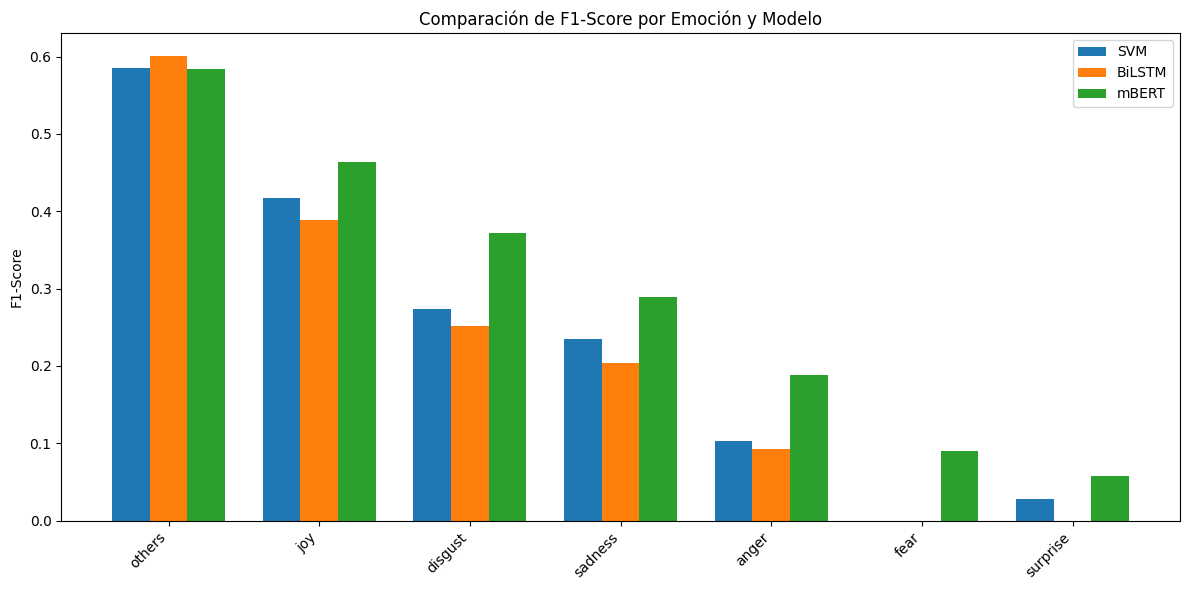

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar los resultados guardados por emoción (asumiendo que ya se generaron los CSVs)
try:
    svm_by_label = pd.read_csv('svm_by_label.csv')
    bilstm_by_label = pd.read_csv('bilstm_by_label.csv')
    bert_by_label = pd.read_csv('bert_by_label.csv')

    # Renombrar columnas de F1 para la comparación en el gráfico
    svm_by_label = svm_by_label.rename(columns={'f1': 'SVM_f1'})
    bilstm_by_label = bilstm_by_label.rename(columns={'f1': 'BiLSTM_f1'})
    bert_by_label = bert_by_label.rename(columns={'f1': 'mBERT_f1'})

    # Combinar solo las etiquetas y los F1 scores para el gráfico
    comparison_f1 = svm_by_label[['label', 'SVM_f1']].merge(
        bilstm_by_label[['label', 'BiLSTM_f1']], on='label'
    ).merge(
        bert_by_label[['label', 'mBERT_f1']], on='label'
    )

    # Ordenar por alguna métrica si se desea (ej: F1 de mBERT)
    comparison_f1 = comparison_f1.sort_values('mBERT_f1', ascending=False)

    print("===== Gráfico de Comparación de F1-Score por Emoción =====")

    # Crear el gráfico de barras agrupadas
    labels = comparison_f1['label']
    svm_f1 = comparison_f1['SVM_f1']
    bilstm_f1 = comparison_f1['BiLSTM_f1']
    bert_f1 = comparison_f1['mBERT_f1']

    x = np.arange(len(labels))  # label locations
    width = 0.25  # width of the bars

    fig, ax = plt.subplots(figsize=(12, 6)) # Ajusta el tamaño si es necesario

    rects1 = ax.bar(x - width, svm_f1, width, label='SVM')
    rects2 = ax.bar(x, bilstm_f1, width, label='BiLSTM')
    rects3 = ax.bar(x + width, bert_f1, width, label='mBERT')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('F1-Score')
    ax.set_title('Comparación de F1-Score por Emoción y Modelo')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.legend()

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: Los archivos CSV de resultados por emoción no fueron encontrados.")
    print("Asegúrate de haber ejecutado las celdas de entrenamiento de los modelos.")
except Exception as e:
    print(f"Ocurrió un error al generar el gráfico por emoción: {e}")

El gráfico evidencia que mBERT es el modelo más robusto, ya que supera a SVM y BiLSTM en la mayoría de las emociones, especialmente en joy, disgust, sadness y anger. Aunque todas las variantes logran buenos resultados en others, BiLSTM alcanza el valor más alto allí. En cambio, fear y surprise resultan las categorías más difíciles, con desempeños muy bajos en general, pero donde mBERT logra una ligera ventaja. En conjunto, se confirma que mBERT ofrece un mejor equilibrio y mayor capacidad de generalización frente a los otros modelos.

===== Gráfico de Comparación de Modelos (F1 promedio por emoción) =====


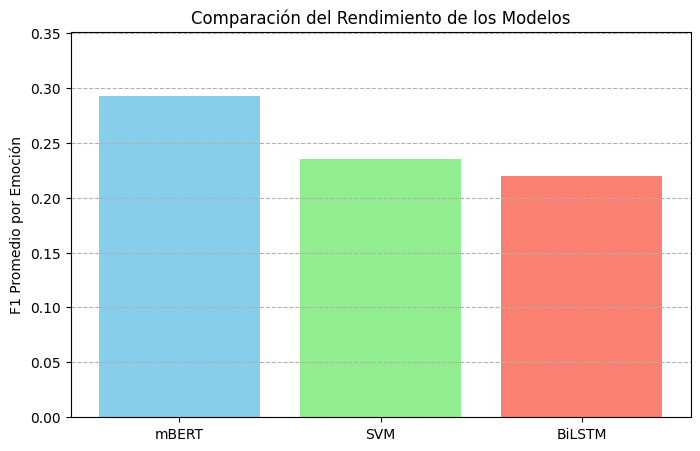

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el resumen de comparación de modelos
try:
    summary_df = pd.read_csv('model_comparison_summary.csv')

    print("===== Gráfico de Comparación de Modelos (F1 promedio por emoción) =====")

    # Crear el gráfico de barras
    plt.figure(figsize=(8, 5))
    plt.bar(summary_df['model'], summary_df['avg_macro_f1_by_label'], color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylabel('F1 Promedio por Emoción')
    plt.title('Comparación del Rendimiento de los Modelos')
    plt.ylim(0, summary_df['avg_macro_f1_by_label'].max() * 1.2) # Ajustar límite superior del eje y
    plt.grid(axis='y', linestyle='--')
    plt.show()

except FileNotFoundError:
    print("Error: El archivo 'model_comparison_summary.csv' no fue encontrado.")
    print("Asegúrate de haber ejecutado la celda que genera este resumen (celda 10).")
except Exception as e:
    print(f"Ocurrió un error al generar el gráfico: {e}")

El gráfico final sintetiza el desempeño promedio de los tres modelos, mostrando con claridad que mBERT obtiene el mejor resultado global, con un F1 promedio cercano al 0.30, superando tanto a SVM como a BiLSTM. Esto confirma la mayor capacidad de mBERT para capturar matices emocionales en los textos, mientras que SVM logra un rendimiento intermedio y BiLSTM se ubica ligeramente por debajo. Con esta comparación se concluye que, dentro de este estudio, mBERT es el modelo más adecuado para la tarea de clasificación de emociones, logrando un mejor balance entre precisión y generalización frente a las demás alternativas evaluadas.